In [103]:
import os
import requests
import tqdm

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import mne

sns.set()

In [60]:
urls = list()
urls.append(["https://dataverse.harvard.edu/api/access/datafile/10648974", "sub-G_task-oddball_run-1_eeg.eeg"]) # 1.eeg
urls.append(["https://dataverse.harvard.edu/api/access/datafile/10648957", "sub-G_task-oddball_run-1_eeg.vhdr"]) # 1.vhdr
urls.append(["https://dataverse.harvard.edu/api/access/datafile/10648959", "sub-G_task-oddball_run-1_eeg.vmrk"]) # 1.vmrk
urls.append(["https://dataverse.harvard.edu/api/access/datafile/10648988", "sub-G_task-oddball_run-2_eeg.eeg"]) # 2.eeg
urls.append(["https://dataverse.harvard.edu/api/access/datafile/10648994", "sub-G_task-oddball_run-2_eeg.vhdr"]) # 2.vhdr
urls.append(["https://dataverse.harvard.edu/api/access/datafile/10648995", "sub-G_task-oddball_run-2_eeg.vmrk"]) # 2.vmrk


In [30]:
def mkdir(dir):
    isExist = os.path.exists(dir)
    if not isExist:
        os.makedirs(dir)
    return dir

def data_dl(url, fname, force_dl = False):
    isExist = os.path.exists(fname)
    if isExist is False or force_dl is True:
        data = requests.get(url, stream = True)
        with open(fname, 'wb') as f:
            for chunk in tqdm.tqdm(data.iter_content(chunk_size = 1024)):
                if chunk:
                    f.write(chunk)
                    f.flush()

In [63]:
home = os.path.expanduser("~")
base_dir = os.path.join(home, "mne_data", "asme-4class", "sub-G")

files = ["sub-G_task-oddball_run-1_eeg.vhdr", "sub-G_task-oddball_run-2_eeg.vhdr"]

In [57]:
mkdir(base_dir)

for url in urls:
    data_dl(url[0], os.path.join(base_dir, "%s"%url[1]), False)

In [88]:
eog_channels = ['vEOG', 'hEOG']

# filter parameters
l_freq = 1.0
h_freq = 40.0
method = 'iir'
iir_params = dict(order = 2,
                 ftype = 'butter',
                 btype = 'bandpass',
                 phase = 'zero')

# epoching
event_id = list()
event_id.append({'event:500Hz/run:1/nontarget':1, 'event:1000Hz/run:1/target':11})
event_id.append({'event:500Hz/run:2/nontarget':1, 'event:1000Hz/run:2/target':11})

tmin = -0.2
tmax = 1.0
baseline = None

In [94]:
epochs_list = list()
for idx, file in enumerate(files):
    raw = mne.io.read_raw_brainvision(os.path.join(base_dir, file),
                                     eog = eog_channels,
                                     preload = True)

    raw.filter(l_freq = l_freq,
              h_freq = h_freq,
              method = method,
              iir_params = iir_params)

    events, event_id_original = mne.events_from_annotations(raw)

    epochs = mne.Epochs(raw = raw,
                       events = events,
                       event_id = event_id[idx],
                       tmin = tmin,
                       tmax = tmax,
                       baseline = baseline)
    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)

Extracting parameters from /Users/simon/mne_data/asme-4class/sub-G/sub-G_task-oddball_run-1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 305959  =      0.000 ...   305.959 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 11')]
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Extracting parameters from /Users/simon/mne_data/asme-4class/sub-G/sub-G_task-oddball_run-2_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 305439  =      0.000 ...   305.439 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40

/var/folders/tm/h112b3gx5vj1yb2rth_4p4700000gn/T/ipykernel_66068/4159404620.py:22: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_list)


Using data from preloaded Raw for 300 events and 1201 original time points ...
Not setting metadata
600 matching events found
No baseline correction applied


In [95]:
print(epochs)

<EpochsArray | 600 events (all good), -0.2 – 1 s (baseline off), ~362.9 MiB, data loaded,
 'event:500Hz/run:1/nontarget': 500
 'event:1000Hz/run:1/target': 100
 'event:500Hz/run:2/nontarget': 500
 'event:1000Hz/run:2/target': 100>


In [112]:
target = epochs['target'].average()
nontarget = epochs['nontarget'].average()

times = epochs.times

(-0.2, 1.0)

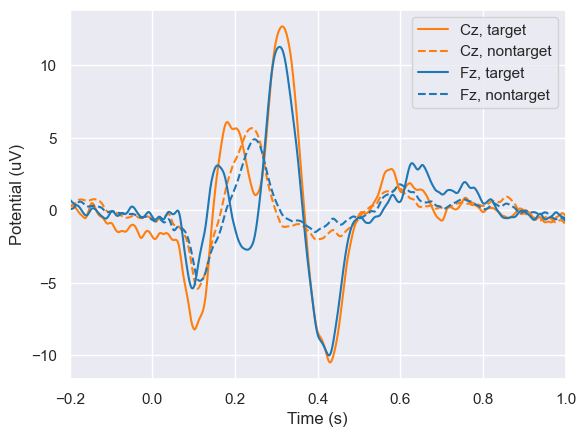

In [119]:
plt.plot(times, np.squeeze(target.copy().pick(picks=['Cz']).get_data()*1e6), color = 'tab:orange', label = "Cz, target")
plt.plot(times, np.squeeze(nontarget.copy().pick(picks=['Cz']).get_data()*1e6), color = 'tab:orange', linestyle = "--", label = "Cz, nontarget")

plt.plot(times, np.squeeze(target.copy().pick(picks=['Fz']).get_data()*1e6), color = 'tab:blue', label = "Fz, target")
plt.plot(times, np.squeeze(nontarget.copy().pick(picks=['Fz']).get_data()*1e6), color = 'tab:blue', linestyle = "--", label = "Fz, nontarget")

plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Potential (uV)")

plt.xlim([tmin, tmax])